In [2]:
import os

dir_path = os.getcwd()
    
# path = os.path.join(dir_path, 'multitraitretrieval/')
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" ### do not use the GPUs

In [3]:
dir_path

'/net/scratch/echerif/gitcodetest/multiTraitPredictions'

In [6]:
from fun_module import *

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import pandas as pd

import time
import multiprocessing

import rasterio
from rasterio.plot import show

import warnings
warnings.filterwarnings("ignore")

In [87]:
enmap_im_path = os.path.join(dir_path, 'HS_img/NEON_D16_ABBY_DP3.tif') #enmap_toyExp NEON_toyExp NEON_sc8 NEON_D16_ABBY_DP3 
bands_path = os.path.join(dir_path, 'HS_img/NEON_bands.csv') #Enmap_bands NEON_bands
path_model = os.path.join(dir_path, 'models/')
sceneText = 'NEON_D16_ABBY_DP3'

In [88]:
###### We provide somw Toy examples of hyperspectral imagery on the repo ######
src, df, idx_null = image_processing(enmap_im_path, bands_path)
df_transformed = transform_data(df)


starting processing
Image transformation took 30.42s total


<AxesSubplot:>

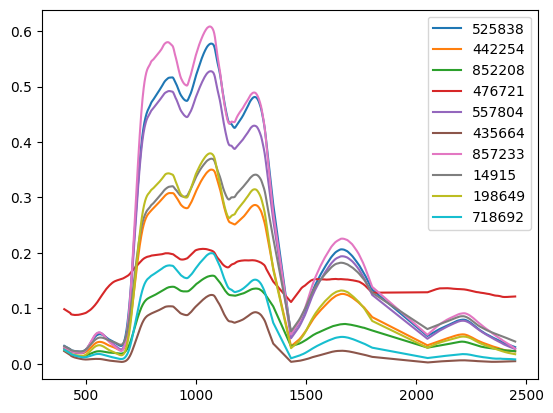

In [89]:
plt.rc('font', size=10)
df_transformed.sample(10).T.plot()

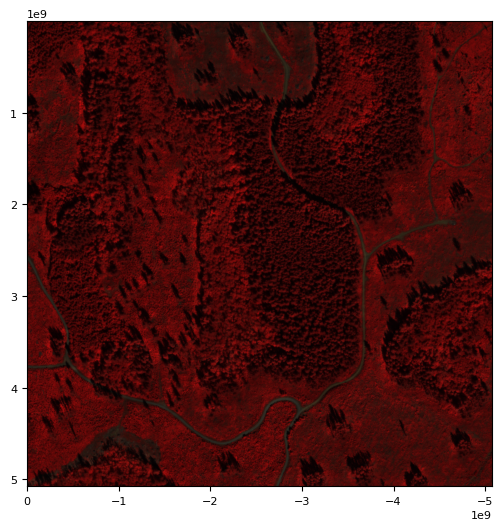

In [90]:
nir = src.read(72)/10000
red = src.read(47)/10000
green = src.read(28)/10000
blue = src.read(6)/10000

# Stack bands
nrg = np.dstack((nir, red, green)) ## False color
# nrg = np.dstack((red, green, blue)) ## Real color

# View the color composite
extent = src.bounds  # Replace with your image's bounding box coordinates

fig = figure(figsize=(6, 9))
plt.rc('font', size=8)
plt.imshow(nrg, extent=extent)

In [11]:
########## Load the trained model ###
best_model, scaler_list = load_model(path_model)

2023-11-13 17:01:37.114895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 17:01:37.115121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 17:01:37.129721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 17:01:37.129994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-13 17:01:37.130232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [91]:
######### Model predictions ########
start_t = time.perf_counter()

print("starting predictions")

tf_preds = scaler_list.inverse_transform(best_model.predict(df_transformed, verbose=1, batch_size=64)) #df_transformed
preds = pd.DataFrame(tf_preds, columns=Traits)

end_t = time.perf_counter()
total_duration = end_t - start_t
print(f"etl took {total_duration:.2f}s total")

preds.loc[idx_null] = np.nan

starting predictions
15625/15625 [==============================] - 699s 45ms/step
etl took 711.44s total


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


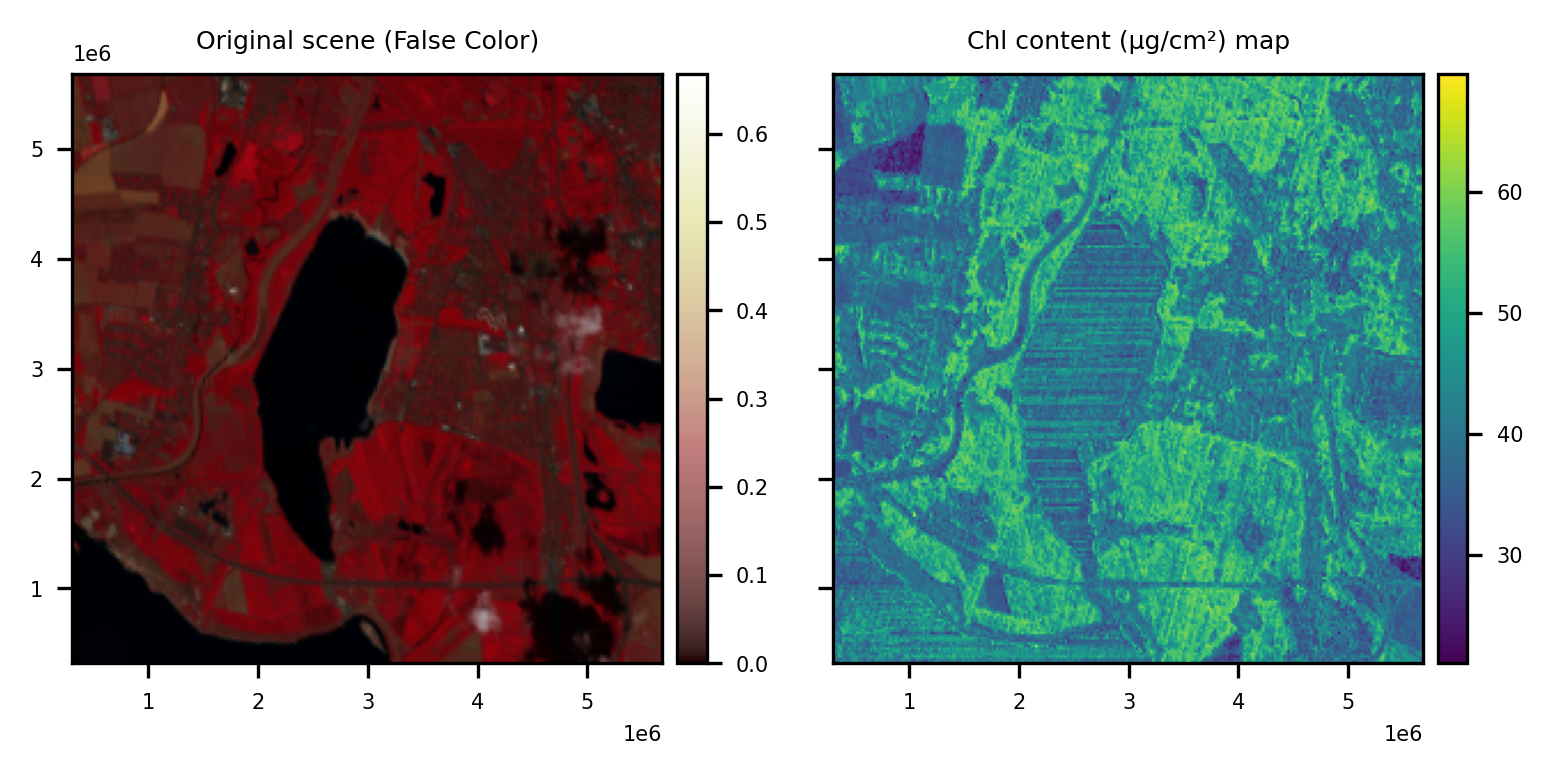

In [82]:
######## stat visualization #######
tr = 4
plt.rc('font', size=5) #5.7

fig , (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 9), dpi=300 ,sharex=True, sharey=True)
extent = src.bounds

ori_im = ax1.imshow(nrg, cmap='pink', extent=extent)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ori_im, cax=cax)

####### for visualization ######
preds_vis = preds.copy()#[preds<preds.quantile(0.99)]
flag = np.array(preds.loc[:,Traits[tr]]).reshape(src.shape[0],src.shape[1])
maxv = pd.DataFrame(flag).max().max()
minv = pd.DataFrame(flag).min().min()

pred_im = ax2.imshow(np.array(preds.loc[:,Traits[tr]]).reshape(src.shape[0],src.shape[1]),vmin= minv, vmax=maxv, extent=extent) ### divergeant : PuOr, BrBG ##gnuplot, BrBG, Greens
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(pred_im, cax=cax)

ax1.set(title= 'Original scene (False Color)')
ax2.set(title= '{} map'.format(Traits[tr]))

plt.show()

In [92]:
########## Save the produced map as geotiff ###
size = (src.height, src.width, len(Traits))
crs = src.crs 
transform = src.transform 
bounds = src.bounds

new_image_path = os.path.join(dir_path, 'HS_img/{}_allTraits.tif'.format(sceneText))
new_image = rasterio.open(new_image_path, 'w',
                          driver='GTiff',
                          width=size[1],
                          height=size[0],
                          count=size[2],  # Change count for multiband
                          dtype='float32',  # Change dtype as per your data
                          crs=crs,
                          transform=transform,
                         bounds= bounds
                         )

for i in range(1,size[2]+1):
    # print(i)
    array_data = np.array(preds.loc[:,Traits[i-1]]).reshape((src.height, src.width))
    new_image.write(array_data,i)  # Change band index for multiband
    
# Close the new image
new_image.close()

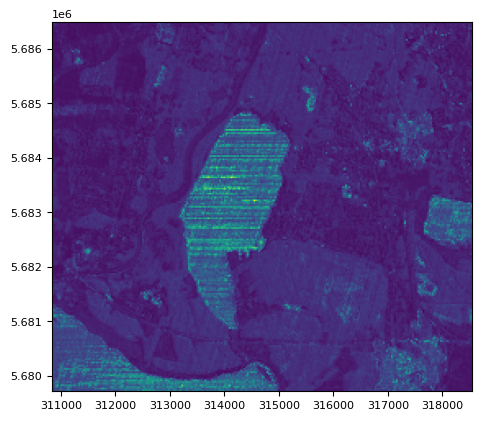

<AxesSubplot:>

In [79]:
src_test = rasterio.open(new_image_path, 'r')
show(src_test)

# src_test